In [4]:
import pandas as pd
import warnings
import matplotlib.pyplot as plt
from src.helper_methods import *
from src.pipe_store import *
warnings.filterwarnings('ignore')


# %matplotlib widget 
%matplotlib inline 
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 2

# Constants

In [5]:
class_I = { '44RMA', '45KE', '56R', '62EE', '62GRN', '62QE', '65QIA', '66NH', '71TD', '73ID', '74Y', '76ED', '76VDT', '80TLR', '94I', '97V', 
           '105S', '144QL', '150AAH', '150AH', '158T', '193AV', '207S', '245AS' }
class_II_dr = {'4Q', '6C', '30D', '30G[DR]', '31FY', '31FH', '32H', '37S', '67F', '70DA', '70DRA', '71A', '74A', '74L', '96EV', '96HK', '108T', '140TV', '142M', '149H'}
class_II_dq = {'45GV','45EV', '46VY'}

RELEVANT_DESA_BAD_OLD = class_I | class_II_dr | class_II_dq 

RELEVANT_DESA_GOOD_OLD = {
    '30C', '37F', '37YV[DQ]', '55PPA', '62LQ', '71ATD', '71QS', '73AN', '73TVS', '80I', '97S', 
    '130Q', '147L', '152A', '152RA', '152RR', '163RW', '173K', '177DT', '180E', '193PL', '267QE',
    '44RT', '245V',
}

RELEVANT_DESA_BAD = {    
    '71TD', '144QL', '70DRA', '80TLR', '70DA', '67F', '76ED', '76ET', '158T', '45EV'
}

RELEVANT_DESA_GOOD = {'163RW', '37FL', '173K', '152RA', '80I'}

In [6]:
l = len(RELEVANT_DESA_BAD_OLD & RELEVANT_DESA_BAD)
print(f'Number of relevant bad DESA that are common in both findings is {l} out of {len(RELEVANT_DESA_BAD)}')

l = len(RELEVANT_DESA_GOOD_OLD & RELEVANT_DESA_GOOD)
print(f'Number of relevant bad DESA that are common in both findings is {l} out of {len(RELEVANT_DESA_GOOD)}')

Number of relevant bad DESA that are common in both findings is 9 out of 10
Number of relevant bad DESA that are common in both findings is 4 out of 5


# Loading Data

In [7]:
path_cohort = '~/UMCUtrecht/KaplanMeier/DESAsurvival.pickle'
path_antibody = '~/UMCUtrecht/20211104_mismatch_ep_db.pickle'
df_abs = pd.read_pickle(path_antibody)
df_cohort = pd.read_pickle(path_cohort)
df = df_abs.merge(df_cohort, on='TransplantID')
cols = [
    'TransplantID', 'DESA_Status', 'EpvsHLA_Donor', '#DESA', 'DESA', 'RecipientAge_NOTR', 
    'DonorAge_NOTR', 'TypeOfDonor_NOTR', 'FailureCode10Y_R', 'GraftSurvival10Y_R', 'IL2rMoAb',
    'CIPHour_DBD', 'CIPHour_DCD' , 'LivingDonorNum', # 'FailureCode10y'
]
df = df[cols]
# df_deceased = df[df.TypeOfDonor_NOTR == 'Deceased'][cols]
# df_living = df[df.TypeOfDonor_NOTR == 'Living'][cols]
df.columns

Index(['TransplantID', 'DESA_Status', 'EpvsHLA_Donor', '#DESA', 'DESA',
       'RecipientAge_NOTR', 'DonorAge_NOTR', 'TypeOfDonor_NOTR',
       'FailureCode10Y_R', 'GraftSurvival10Y_R', 'IL2rMoAb', 'CIPHour_DBD',
       'CIPHour_DCD', 'LivingDonorNum'],
      dtype='object')

### 1. Method to calculate / define DESA has to be described in more detail > maybe good to add this information in Supplemental Material?
    
    Definition of DESA is already provided. We can provide some more explenation on the method we have used to choose clinical relevant DESA. 
    


### 2. How did you define clinical relevance of DESA > add to Material&Method
    
    We have already did so.

### 3. Why chosen for the HLA epitope registry?

    Maybe domain expert can adress this question better.
    The question is asked by Sebastiaan and the context is as follow

    “To define donor specific HLA epitopes, several algorithms are available (e.g., HLA Matchmaker, OLI Fusion Matchmaker, HLA Epitope Registry), but there are differences in eplet definitions between those algorithms (12). Finally, epitope definitions have been subject to change, especially for HLA-DQ (13), showing that there is no definitive and accepted list of eplets.”

### 4. Which Follow Up time frame did you use to define clinically relevant DESA?
    
    10-year time window.

### 5. Which definition for GS did you use (overall-GS or death-censored GS)?
    
    death-censored GS [Make sure to mention this in the material and method]

### 6. Could you calculate GS with 71 clinically relevant DESA (both ‘bad’ and ‘good’ ones) with a confidence interval?
    
    We have to do a follow up to clarify the question.
    
    Technically we can not make 1 Kaplan meier plots for both bad & good DESA since there are 5 transplant that do have both. However, we can make separate ones which we already have.

### 7. In how many patients are both ‘bad’ and ‘good’ DESA present?

In [8]:
ind_bad = df[df.TypeOfDonor_NOTR == 'Deceased'].DESA.apply(lambda x: bool(x & RELEVANT_DESA_BAD))
ind_good = df[df.TypeOfDonor_NOTR == 'Deceased'].DESA.apply(lambda x: bool(x & RELEVANT_DESA_GOOD))

In [9]:
print(f'Number of patients with Bad DESA: {ind_bad.sum()}')
print(f'Number of patients with Good DESA: {ind_good.sum()}')
print(f'Number of patients with both Baad & Good DESA: {(ind_bad & ind_good).sum()}')

Number of patients with Bad DESA: 55
Number of patients with Good DESA: 47
Number of patients with both Baad & Good DESA: 2


### 8. How to deal with relevant and non relevant DESA? Is it possible that they level each other out?

        Porbably yes!

        - How many patients have relevant & irrelevant desa? 
              -> According to above analysis 5 Tx
        - Among the 106 tx with relevant DESA what percentage has good or irrelevant DESA? 
              ->  Among the 106 Tx for deceased donors. 5 Tx has also good DESA and the rest irrelevant DESA.
        - Could patients with irrelevant DESA have some clinically relevant DESA? 
              -> yes

### 9. DESA: which loci, # per patient (median – range), MFI (median – range), etc.
        - At which HLA Locus (A, B, C, DR, DQ) the Relevant DESA are pointing? 
        - How many relevant DESA exist in each patient?

In [10]:
get_rel_hla = lambda x: {hla.split('*')[0] for ep, hla in x.items() if ep in RELEVANT_DESA_BAD}
r = df[(df.TypeOfDonor_NOTR == 'Deceased') & (df.DESA_Status == 'DESA')]['EpvsHLA_Donor'].apply(get_rel_hla).value_counts()
r
# Column left: The set of HLA Locus at which relevant DESA are pointing
# Column right: number of Tx
# i.e.: 167 Tx do not have any relevant DESA

{}              260
{B}              27
{DQB1}           18
{DRB1}            5
{DRB5}            3
{DRB1, DRB5}      1
{A}               1
Name: EpvsHLA_Donor, dtype: int64

Henny Comment: Break down the numbers per HLA group!

In [11]:
from collections import defaultdict  

agg = defaultdict(lambda: 0, {})
for item in r.iteritems():
    hlas, num_tx = item[0], item[1]
    for hla in hlas:
        agg[hla] += num_tx

In [12]:
agg

defaultdict(<function __main__.<lambda>()>,
            {'B': 27, 'DQB1': 18, 'DRB1': 6, 'DRB5': 4, 'A': 1})

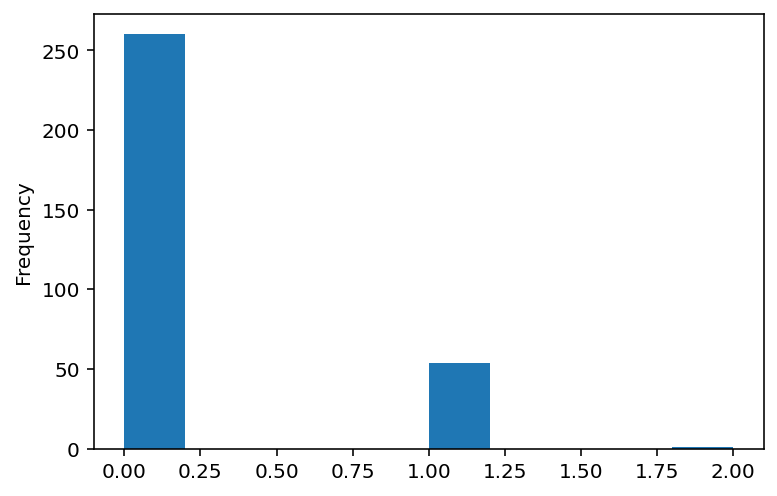

In [13]:
# X-axis: Number of HLA at which each relevant DESA is pointing
# Y-axis: Number of Tx 
(
    df[(df.TypeOfDonor_NOTR == 'Deceased') & (df.DESA_Status == 'DESA')]['EpvsHLA_Donor']
    .apply(lambda x: len(get_rel_hla(x))).plot.hist() 
);

In [14]:
df[(df.TypeOfDonor_NOTR == 'Deceased') & (df.DESA_Status == 'DESA')]['DESA'].apply(lambda x: len(x & RELEVANT_DESA_BAD)).value_counts()

# Column left: Number of relevant DESA in each transplant
# Column right: Number of Tx
# i.e.: 209 Tx do not have any relevant DESA and 68 Tx have 1 DESA

0    260
1     37
2      8
3      7
4      3
Name: DESA, dtype: int64

 Henny's comments: Put this table/data as a dist/hist plot figure in the suplement

### 10. Regarding the 47 epitopes found to be related to graft loss: Class I or II, MFI compared to non relevant DESA, interlocus DESA?
        - the relevant DESA are both Claas I (24) and Class II (6). 
        - Question on MFI: Is this relevant, given that we already know that MFI is nor clinically relevant? provide the mean MFI?

### 11. Idem for the 24 epitopes found to be related to graft survival?

        - Is this the relevant good DESA?  

### 12. Number of clinically relevant DESA per patient? In deceased donors 148 patients do have relevant DESA (meaning 3x per DESA on average). What is the presence of these relevant DESA in patients in the other DESA group?

        - There is no record of relevant DESA in the blue group.
        - How many times the good desa are present in the red group? 41 times

### 13. Figure 2: are the different colors of DESA the same?

Yes!! Question is vague

### 14. Figure 3: p-value Figure 3D and Figure 3F
- With the new analysis all the figures are now statistically significant.

### 15. Description what is a virtual HLA molecule?

Question is vague

### 16. Tineke Follow-up question: I also need detailed information about all DESAs (loci, number per patient).

In [40]:
df_dead = df[df['TypeOfDonor_NOTR'] == 'Deceased']
list_set_desa = df_dead[df_dead.DESA_Status == 'DESA'].DESA.values
desas = {ep for desa_set in list_set_desa for ep in desa_set}
len(desas)

304

In [42]:
get_hla = lambda x: {hla.split('*')[0] for ep, hla in x.items()}
hla_vs_desa = df_dead[df_dead.DESA_Status == 'DESA']['EpvsHLA_Donor'].apply(get_hla).value_counts()
hla_vs_desa

{A}                         69
{B}                         54
{DQB1}                      37
{DRB1}                      24
{B, A}                      17
{C}                         13
{DRB3}                      12
{DRB4}                       7
{DRB3, DRB1}                 6
{B, C}                       6
{DQB1, DRB1}                 5
{DRB1, DRB5}                 5
{DRB1, B}                    4
{DRB4, DRB1}                 4
{A, C}                       4
{DQB1, A}                    4
{DRB1, A}                    3
{DRB5}                       2
{DQA1, DQB1}                 2
{DRB3, DRB1, A}              2
{B, A, C}                    2
{DQB1, C}                    2
{DQA1, DRB1, DQB1}           2
{DQB1, DRB4}                 2
{DQB1, DRB1, A}              2
{DQB1, DRB4, B}              1
{DRB3, C}                    1
{DQB1, DRB1, DRB5}           1
{DQB1, DRB1, C}              1
{DRB4, DRB1, A, C}           1
{DRB3, DQB1, DRB1}           1
{DQB1, DRB4, DRB1}           1
{DRB3, B